In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd
from scipy.constants import c
from scipy.integrate import quad

#Nested sampling package
import ultranest
import corner

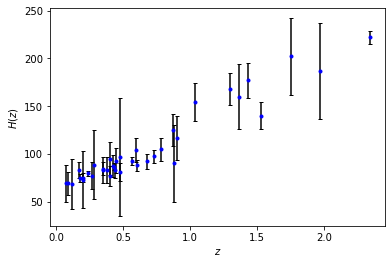

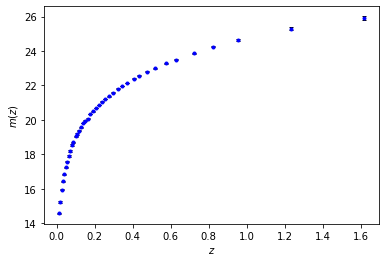

In [2]:
# Import Hubble H(z) data

hubble_data = pd.read_csv('hubble_data.csv', header=0)

z_H = np.array(hubble_data['z'])
H = np.array(hubble_data['H'])
dH = np.array(hubble_data['dH'])

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

# Import apparent magnitude m(z) data
m_data = pd.read_csv('m_data.txt', sep = ' ', header = 0)
m_sys_unc = pd.read_csv('m_sys_unc.txt', sep = ' ', header = 0)
m_sys_unc = np.array(m_sys_unc['40']).reshape(40, 40)

tot = m_sys_unc + np.diag(m_data['dmb']**2)

z_m = np.array(m_data['zcmb'])
m = np.array(m_data['mb'])
dm = np.sqrt(np.diag(tot))

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

# Combine redshifts for likelihood computation later
combined_z = []
combined_z.append(z_H)
combined_z.append(z_m)

# Combine data
combined_data = []
combined_data.append(H)
combined_data.append(m)

# Combine uncertainties
combined_unc = []
combined_unc.append(dH)
combined_unc.append(dm)

In [3]:
'Define Cosmic Strings Model'
def CosmicStrings(z, params):
    H0 = params[0] 
    OM = params[1] 
    OS = params[2]
    return H0*np.sqrt(OM*(1+z)**3 + OS*(1+z)**(1/3))

'Define Phantom Energy Model'
def PhantomEnergy(z, params):
    H0 = params[0] 
    OM = params[1] 
    OP = params[2]
    w_p = params[3]

    return H0*np.sqrt(OM*(1+z)**3 + OP*(1+z)**(3*(1+w_p)))

'Define apparent magnitude function'
def ApparentMagnitude(z, Hubble, params):
    
    def integrand_dl(z, Hubble, params):
    #integrand of luminosity distance formula
        return params[0]/Hubble(z, params)

    def dl(z, Hubble, params):
    #dimensionless luminosity distance at redshift z (input array)
        rz_array = np.zeros(len(z))
        for i in np.arange(len(z)):
            rz_each = quad( integrand_dl, 0, z[i],
                        args = (Hubble, params) )[0]
            rz_array[i] = rz_each
            
        return (1+z)*rz_array
    
    return 5*np.log10((c*100/params[0])*dl(z, Hubble, params)) - 19.25

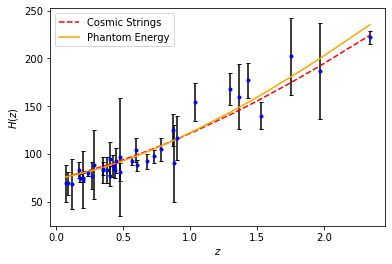

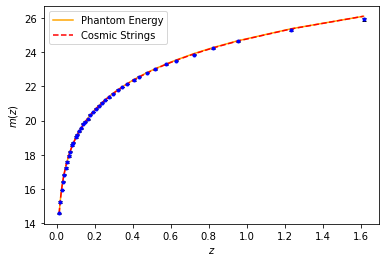

In [4]:
params_cosmicstrings = [74.96, 0.21, 0.75]
params_phantomenergy = [74.50, 0.25, 0.73, -1.03]

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_H, CosmicStrings(z_H, params_cosmicstrings), color='red', ls='--', label='Cosmic Strings')
plt.plot(z_H, PhantomEnergy(z_H, params_phantomenergy), color='orange', label='Phantom Energy')
plt.legend(loc='best')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_m, ApparentMagnitude(z_m, PhantomEnergy, params_phantomenergy), color='orange', label='Phantom Energy')
plt.plot(z_m, ApparentMagnitude(z_m, CosmicStrings, params_cosmicstrings), color='red', ls='--', label='Cosmic Strings')
plt.legend(loc='best')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

## Nested Sampling

In [18]:
def Prior_CS(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #OM Prior: [0,1]
    OM_min = 0
    OM_max = 1
    
    #OL Prior: [0,1]
    OS_min = 0
    OS_max = 1 
    
    #Extract values
    H0prime = cube[0]
    OMprime = cube[1]
    OSprime = cube[2]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    OM = OMprime*(OM_max-OM_min) + OM_min
    OS = OSprime*(OS_max-OS_min) + OS_min
        
    return np.array([H0, OM, OS])
    
def LogLikelihood_CS(params):
        

    # calculate the model
    hubble_model = CosmicStrings(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, CosmicStrings, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [19]:
t_i = time()
sampler_CS = ultranest.ReactiveNestedSampler(['H0', 'OM', 'OS'], LogLikelihood_CS, Prior_CS)
result_CS = sampler_CS.run()
sampler_CS.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-36.6177..-36.6177]*| it/evals=5768/126097 eff=4.5888% N=400        00 0  
[ultranest] Likelihood function evaluations: 126097
[ultranest]   logZ = -46.44 +- 0.1227
[ultranest] Effective samples strategy satisfied (ESS = 1644.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.39, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.

logZ = -46.429 +- 0.386
  single instance: logZ = -46.429 +- 0.148
  bootstrapped   : logZ = -46.439 +- 0.386
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  77.4 +- 9.6
    OM                  0.207 +- 0.049
    OS                  0.73 +- 0.17
Sampling time: 835.865061044693 s


In [57]:
points_CS = np.array(result_CS["weighted_samples"]["points"])
weights_CS = np.array(result_CS["weighted_samples"]["weights"])
scaledweights_CS = weights_CS / weights_CS.max()
mask_CS = np.random.rand(len(scaledweights_CS)) < scaledweights_CS

samples_CS = points_CS[mask_CS, :]

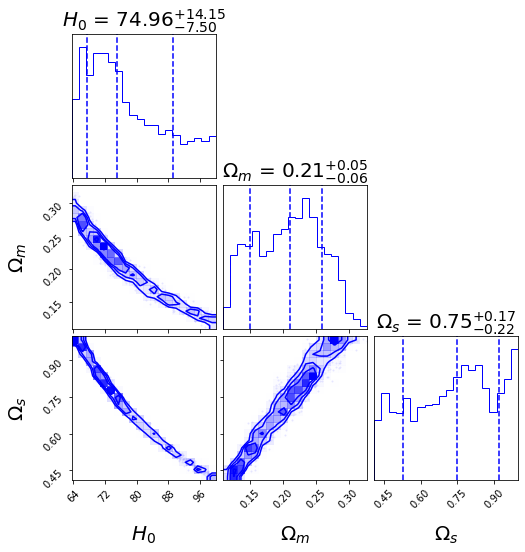

In [59]:
# Extract and compile chains
CosmicStrings_chain_1 = samples_CS[:,0] # extract chain of H0 values
CosmicStrings_chain_2 = samples_CS[:,1] # extract chain if OM values
CosmicStrings_chain_3 = samples_CS[:,2] # extract chain if OL values
CosmicStrings_samples = np.vstack((CosmicStrings_chain_1, CosmicStrings_chain_2, CosmicStrings_chain_3)).T

# Save chains and evidence (do not forget)
np.savetxt('CosmicStrings_chains_Aug11_728PM.csv', CosmicStrings_samples, delimiter=",")
np.savetxt('CosmicStrings_Z_Aug11_728PM.csv', [[result_CS['logz'] , result_CS['logzerr']]])

# Open saved chains
samples_open =  open_samples('CosmicStrings_chains_Aug11_728PM.csv')


fig = corner.corner(samples_open, labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_s$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('CosmicStrings_Aug11_728PM.pdf')

In [72]:
def Prior_PE(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #OM Prior: [0,1]
    OM_min = 0
    OM_max = 1
    
    #OP Prior: [0,1]
    OP_min = 0
    OP_max = 1 
    
    #w_p
    w_p_min = -3
    w_p_max = -1.01
    
    #Extract values
    H0prime = cube[0]
    OMprime = cube[1]
    OPprime = cube[2]
    w_pprime = cube[3]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    OM = OMprime*(OM_max-OM_min) + OM_min
    OP = OPprime*(OP_max-OP_min) + OP_min
    w_p = w_pprime*(w_p_max-w_p_min) + w_p_min
        
    return np.array([H0, OM, OP, w_p])
    
def LogLikelihood_PE(params):
        

    # calculate the model
    hubble_model = PhantomEnergy(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, PhantomEnergy, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [73]:
t_i = time()
sampler_PE = ultranest.ReactiveNestedSampler(['H0', 'OM', 'OP', 'w_p'], LogLikelihood_PE, Prior_PE)
result_PE = sampler_PE.run()
sampler_PE.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-37.8285..-37.8284]*| it/evals=7209/205511 eff=3.5147% N=400         00 0  
[ultranest] Likelihood function evaluations: 205511
[ultranest]   logZ = -51.23 +- 0.1473
[ultranest] Effective samples strategy satisfied (ESS = 2055.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.40, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -51.199 +- 0.244
  single instance: logZ = -51.199 +- 0.170
  bootstrapped   : logZ = -51.234 +- 0.244
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  76.6 +- 9.9
    OM                  0.254 +- 0.061
    OP                  0.72 +- 0.17
    w_p                 -1.037 +- 0.024
Sampling time: 1568.8902969360352 s


In [74]:
points_PE = np.array(result_PE["weighted_samples"]["points"])
weights_PE = np.array(result_PE["weighted_samples"]["weights"])
scaledweights_PE = weights_PE / weights_PE.max()
mask_PE = np.random.rand(len(scaledweights_PE)) < scaledweights_PE

samples_PE = points_PE[mask_PE, :]

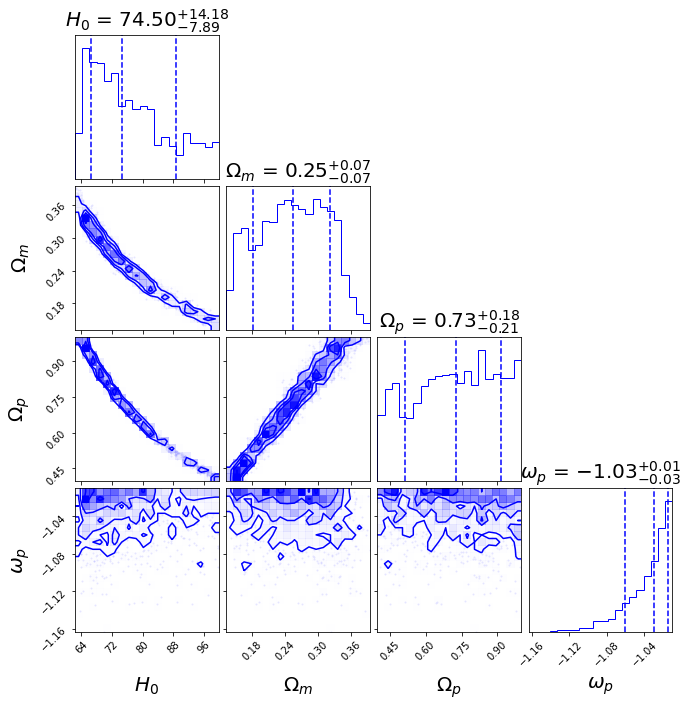

In [78]:
# Extract and compile chains
PhantomEnergy_chain_1 = samples_PE[:,0] # extract chain of H0 values
PhantomEnergy_chain_2 = samples_PE[:,1] # extract chain if OM values
PhantomEnergy_chain_3 = samples_PE[:,2] # extract chain if OL values
PhantomEnergy_chain_4 = samples_PE[:,3] # extract chain if w_p values
PhantomEnergy_samples = np.vstack((PhantomEnergy_chain_1, PhantomEnergy_chain_2, PhantomEnergy_chain_3, PhantomEnergy_chain_4)).T

# Save chains and evidence (do not forget)
np.savetxt('PhantomEnergy_chains_Aug11_728PM.csv', PhantomEnergy_samples, delimiter=",")
np.savetxt('PhantomEnergy_Z_Aug11_728PM.csv', [[result_PE['logz'] , result_PE['logzerr']]])

# Open saved chains
samples_open =  open_samples('PhantomEnergy_chains_Aug11_728PM.csv')


fig = corner.corner(samples_open, labels=[r"$H_0$", r"$\Omega_m$", r"$\Omega_p$",r"$\omega_p$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('PhantomEnergy_Aug11_728PM.pdf')